# Personalizing next-item relevance via psychology-based interest in music recommender systems

Author: Laura Legat

Matriculation ID: 51868012

In [1]:
# import access to Google Drive files

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import needed libraries

import os
import torch
import sys
import pandas as pd
import importlib

!pip install optuna
import optuna
import pickle
import matplotlib.pyplot as plt
import json
import numpy as np
from ast import literal_eval
from collections import OrderedDict
import warnings
import seaborn as sns

!pip install tensorboardX

print('\nAll imports successful!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.5 MB/s eta 0:00:00

All imports successful!


In [3]:
# Check if gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_name = torch.cuda.get_device_name(device)
    print(f'Using GPU: {device_name}')
else:
    device = torch.device('cpu')
    print('Using CPU')

print(f'Current device: {device}')

Using GPU: Tesla T4
Current device: cuda


# Data preparation and preprocessing

In [ ]:
# create train-val-test sets for Ex2Vec training, as well as sequences for GRU4Rec training
SEQ_LEN = 50
!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/preprocess.py -sl 50 -st 1 -sm Y

Pre-processing dataset for Ex2Vec...
Saved processed.csv
Pre-processing dataset for GRU4Rec...
Saved sequenced files for GRU4Rec


In [ ]:
# import custom code

# Append the directory containing 'data_sampler' and 'ex2vec' to Python's search path
sys.path.append('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI')

# imports modules for preparing data and for training/evaluating the ex2vec model
import data_sampler
from data_sampler import evaluate_data, get_rel_int_dict, update_rel_int_dict
from ex2vec import Ex2VecEngine
import ex2vec

#import dir of gru4rec_pytorch module to python path in order to be able to access GRU4Rec model class to be able to load it
sys.path.append('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork')
import gru4rec_pytorch
from evaluation import batch_eval

The size of the training set is: 2173
The size of the validation set is: 308
The size of the test set is: 626
The size of the combined (train+val) set is: 2481


In [ ]:
# convert best parameters to parameter string
def convert_to_param_str(best_param_path):
  with open(best_param_path, 'r') as f:
    data = json.load(f)

  params = data['best_params'] # extract only the parameter part
  param_str = ','.join([f'{key}={value}' for key,value in params.items()])

  return param_str

# Training baseline Ex2Vec

In [ ]:
# train standard ex2vec baseline (no GRU4rec item embeddings, no hyperparameter tuning)
!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -n ex2vec_baseline_DEL

The size of the training set is: 2173
The size of the validation set is: 308
The size of the test set is: 626
The size of the combined (train+val) set is: 2481
Ex2Vec model is created with the following parameters for this run:

alias:ex2vec_baseline_DEL__BS512LR5e-05L_DIM64N_EP100
num_epoch:100
batch_size:512
optimizer:adam
lr:5e-05
rmsprop_alpha:0.99
momentum:0
n_users:5
n_items:186
latent_dim:64
num_negative:0
l2_regularization:0.001
use_cuda:True
device_id:0
pretrain:False
pretrain_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/Ex2Vec_pretrained.pt
model_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/{}_Epoch{}_f1{:.4f}.pt
chckpt_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/chckpts/{}_Epoch{}_f1{:.4f}.pt
Using validation set for evaluation

Started training model:  ex2vec_baseline_DEL__BS512LR5e-05L_DIM64N_EP100
Epoch 0 starts...
100% 5/5 [00:01<00:00,  3.26it/s]
[Evaluating Epoch 0] ACC = 0.5227, B_ACC = 0.5000, RE

In [ ]:
# hyperparameter tuning standard ex2vec
!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optuna_paropt.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/processed.csv -opf /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/paramspaces/deezer_parspace_Ex2Vec.json -nt 2 -p /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -o /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec.json -mo ex2vec -ovc /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/results/optuna_vis_ex2vec.csv -ovp /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec.pkl -sp "sqlite:////content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec.db" -sn "ex2vec_study1" -a "ex2vec_baseline_tuning"

--------------------------------------------------------------------------------
PARAMETER SPACE:
	PARAMETER name=num_epoch 	 type=categorical 	 options: [30,50,100]
	PARAMETER name=batch_size 	 type=categorical 	 options: [256,512,1024,2048]
	PARAMETER name=learning_rate 	 type=float 	 range=[1e-05..0.001] (step=N/A) 	 LOG scale
	PARAMETER name=rmsprop_alpha 	 type=float 	 range=[0.3..1.0] (step=0.1) 	 UNIFORM scale
	PARAMETER name=momentum 	 type=float 	 range=[0.0..0.9] (step=0.05) 	 UNIFORM scale
	PARAMETER name=l2_regularization 	 type=float 	 range=[1e-05..0.01] (step=N/A) 	 LOG scale
--------------------------------------------------------------------------------
[I 2024-09-15 18:13:43,137] Using an existing study with name 'ex2vec_study1' instead of creating a new one.
The size of the training set is: 307730
The size of the validation set is: 43627
The size of the test set is: 88834
The size of the combined (train+val) set is: 351357
Ex2Vec model is created with the following p

In [ ]:
# re-train ex2vec with best parameters (no GRU4Rec item embeddings)
ex2vec_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec.json')

command = f'python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -ps {ex2vec_best_param_str} -t N -n ex2vec_baseline_finaltrain_DEL -ud 1'
get_ipython().system(command)

The size of the training set is: 2173
The size of the validation set is: 308
The size of the test set is: 626
The size of the combined (train+val) set is: 2481
Ex2Vec model is created with the following parameters for this run:

alias:ex2vec_baseline_finaltrain_DEL__BS512LR0.0003208416119525183L_DIM64N_EP30
num_epoch:30
batch_size:512
optimizer:adam
lr:0.0003208416119525183
rmsprop_alpha:0.6000000000000001
momentum:0.8
n_users:5
n_items:186
latent_dim:64
num_negative:0
l2_regularization:8.400584873492367e-05
use_cuda:True
device_id:0
pretrain:False
pretrain_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/Ex2Vec_pretrained.pt
model_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/{}_Epoch{}_f1{:.4f}.pt
chckpt_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/chckpts/{}_Epoch{}_f1{:.4f}.pt
Using combined training set.
Using test set for evaluation

Started training model:  ex2vec_baseline_finaltrain_DEL__BS512LR0.0003208416119525

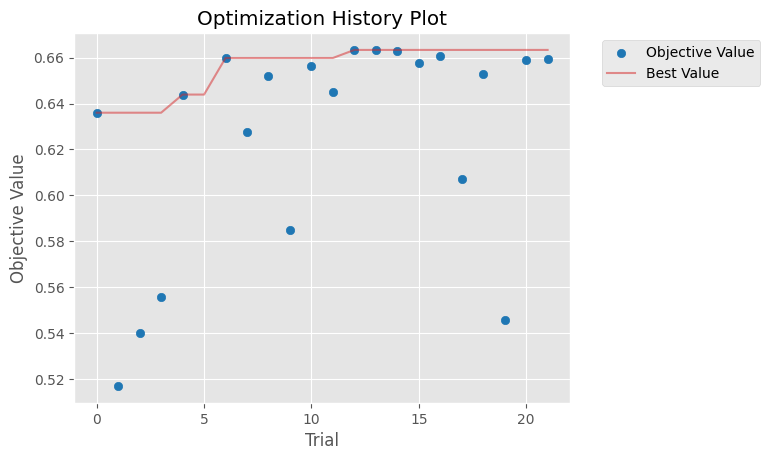

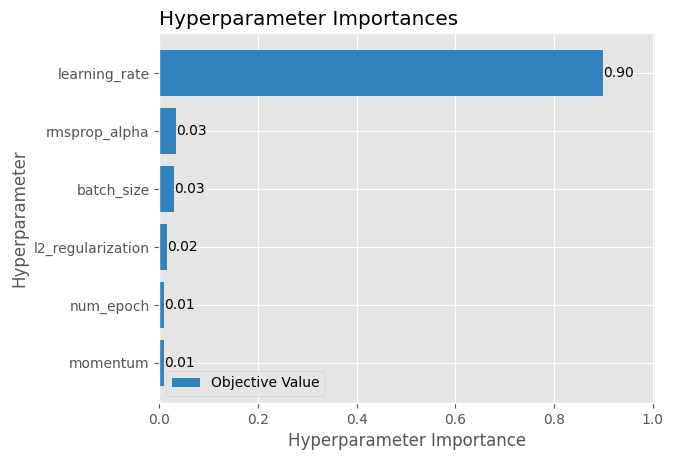

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_l2_regularization,params_learning_rate,params_momentum,params_num_epoch,params_rmsprop_alpha,state,acc,recall,f1,bacc,search_space_id
0,0,0,0.636015,2024-09-14 21:47:06.867567,2024-09-14 21:56:41.253227,0 days 00:09:34.385660,2048,0.000590,0.000122,0.35,100,1.0,COMPLETE,0.642973,0.778575,0.636015,0.641671,1.0
1,1,1,0.517041,2024-09-14 21:56:41.292401,2024-09-14 22:06:37.240553,0 days 00:09:55.948152,1024,0.003137,0.000013,0.00,100,0.7,COMPLETE,0.526692,0.666455,0.517041,0.525350,1.0
2,2,2,0.540086,2024-09-14 22:06:37.278480,2024-09-14 22:09:46.158109,0 days 00:03:08.879629,1024,0.000034,0.000021,0.55,30,0.8,COMPLETE,0.543287,0.625630,0.540086,0.542497,1.0
3,3,3,0.555555,2024-09-14 22:09:46.197290,2024-09-14 22:12:56.177007,0 days 00:03:09.979717,1024,0.000706,0.000072,0.45,30,0.8,COMPLETE,0.565888,0.716271,0.555555,0.564444,1.0
4,4,4,0.643917,2024-09-14 22:12:56.211751,2024-09-14 22:24:22.332948,0 days 00:11:26.121197,512,0.000496,0.000094,0.55,100,0.4,COMPLETE,0.651592,0.795559,0.643917,0.650209,1.0
5,5,5,NaN,2024-09-14 22:24:23.656117,2024-09-14 22:26:22.168857,0 days 00:01:58.512740,256,0.000128,0.000045,0.20,50,0.8,FAIL,NaN,NaN,NaN,NaN,NaN
6,6,6,0.659849,2024-09-14 22:37:41.005321,2024-09-14 22:42:28.642081,0 days 00:04:47.636760,256,0.000030,0.000374,0.40,30,0.7,COMPLETE,0.662457,0.747741,0.659849,0.661638,3.0
7,7,7,0.627545,2024-09-14 22:47:10.009447,2024-09-14 22:52:10.204689,0 days 00:05:00.195242,1024,0.000025,0.000104,0.25,50,0.5,COMPLETE,0.629312,0.696472,0.627545,0.628667,4.0
8,8,8,0.651925,2024-09-14 22:52:10.246843,2024-09-14 22:59:52.551732,0 days 00:07:42.304889,256,0.000604,0.000582,0.55,50,0.4,COMPLETE,0.657185,0.777485,0.651925,0.656029,4.0
9,9,9,0.584995,2024-09-14 22:59:52.590245,2024-09-14 23:04:54.902884,0 days 00:05:02.312639,1024,0.000169,0.000038,0.00,50,0.8,COMPLETE,0.589497,0.691885,0.584995,0.588514,4.0


In [ ]:
warnings.filterwarnings('ignore')
# visualize optuna results for ex2vec
# Load study from pickle file
with open('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec.pkl', 'rb') as f:
    study = pickle.load(f)

# Load trials data from CSV
trials_df = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/results/optuna_vis_ex2vec.csv')

# Optuna visualizations
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

#optuna.visualization.matplotlib.plot_parallel_coordinate(study)
#plt.show()

#optuna.visualization.matplotlib.plot_slice(study)
#plt.show()

#optuna.visualization.matplotlib.plot_edf(study)
#plt.show()

# Display the trials DataFrame
display(trials_df)


In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/runs

# Training GRU4Rec

In [ ]:
# initial training + hyperparameter optimization with seq_train.csv and seq_val.csv on GRU4Rec
!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optuna_paropt.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_train.csv -opf /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/paramspaces/deezer_parspace_GRU4Rec.json -nt 1 -p /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/run.py -o /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_gru4rec.json -mo gru4rec -t /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_val.csv -m "1 5 10 20" -ik "itemId" -tk "timestamp" -ovc /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/results/optuna_vis_gru4rec.csv -ovp /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_gru4rec.pkl -s /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams.pt -sp "sqlite:////content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_gru4rec.db" -sn "gru4rec_study1"

--------------------------------------------------------------------------------
PARAMETER SPACE:
	PARAMETER name=loss 	 type=categorical 	 options: [bpr-max,cross-entropy]
	PARAMETER name=constrained_embedding 	 type=categorical 	 options: [False,True]
	PARAMETER name=embedding 	 type=categorical 	 options: [0,64]
	PARAMETER name=elu_param 	 type=categorical 	 options: [0.5,1,0]
	PARAMETER name=layers 	 type=int 	 range=[64..64] (step=1) 	 UNIFORM scale
	PARAMETER name=n_epochs 	 type=categorical 	 options: [5,7,10,15]
	PARAMETER name=batch_size 	 type=int 	 range=[128..512] (step=16) 	 UNIFORM scale
	PARAMETER name=dropout_p_embed 	 type=float 	 range=[0.0..0.5] (step=0.05) 	 UNIFORM scale
	PARAMETER name=dropout_p_hidden 	 type=float 	 range=[0.0..0.7] (step=0.05) 	 UNIFORM scale
	PARAMETER name=learning_rate 	 type=float 	 range=[0.0001..0.05] (step=0.001) 	 UNIFORM scale
	PARAMETER name=momentum 	 type=float 	 range=[0.0..0.9] (step=0.05) 	 UNIFORM scale
	PARAMETER name=n_sample 	

In [ ]:
# combine seq_train and seq_val to seq_combined.csv for final training/eval

train_csv = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_train.csv')
val_csv = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_val.csv')

# remove header row from the second df
val_csv = val_csv.iloc[0:].reset_index(drop=True)

# stack rows of both csv's
combined_csv = pd.concat([train_csv, val_csv], ignore_index=True)

# Save the combined DataFrame
combined_csv.to_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_combined.csv', index=False)

In [ ]:
# retrain gru4rec with best params
"""
params: (from https://github.com/hidasib/GRU4Rec/blob/master/README.md)
  -t    Testset path
  -pf   Parameter file path
  -s    Path to save the state dict to
  -m    Calculate recall, MRR etc. at the given list length
  -ik   Item key
  -tk   Timestamp key
  -d    Device
"""

gru4rec_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_gru4rec_DEL.json')

command = f'python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/run.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_combined.csv -ps {gru4rec_best_param_str} -t /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_test.csv -s /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams_SM_DEL.pt -m 1 5 10 20 -ik "itemId" -tk "timestamp" -pm recall -lpm'
get_ipython().system(command)

[1, 5, 10, 20]
The size of the training set is: 2173
The size of the validation set is: 308
The size of the test set is: 626
The size of the combined (train+val) set is: 2481
Creating GRU4Rec model on device "cuda:0"
SET   loss                    TO   bpr-max               (type: <class 'str'>)
SET   constrained_embedding   TO   True                  (type: <class 'bool'>)
SET   embedding               TO   0                     (type: <class 'int'>)
SET   elu_param               TO   0.0                   (type: <class 'float'>)
SET   layers                  TO   [64]                  (type: <class 'list'>)
SET   n_epochs                TO   5                     (type: <class 'int'>)
SET   batch_size              TO   320                   (type: <class 'int'>)
SET   dropout_p_embed         TO   0.30000000000000004   (type: <class 'float'>)
SET   dropout_p_hidden        TO   0.15000000000000002   (type: <class 'float'>)
SET   learning_rate           TO   0.0011                (type: 

In [ ]:
# optional: move model to GPU for inference
cpu_model = '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams.pt'

gru4rec_model = torch.load(cpu_model)

gru4rec_model.to('cuda')
torch.save(gru4rec_model, '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams_cuda.pt')

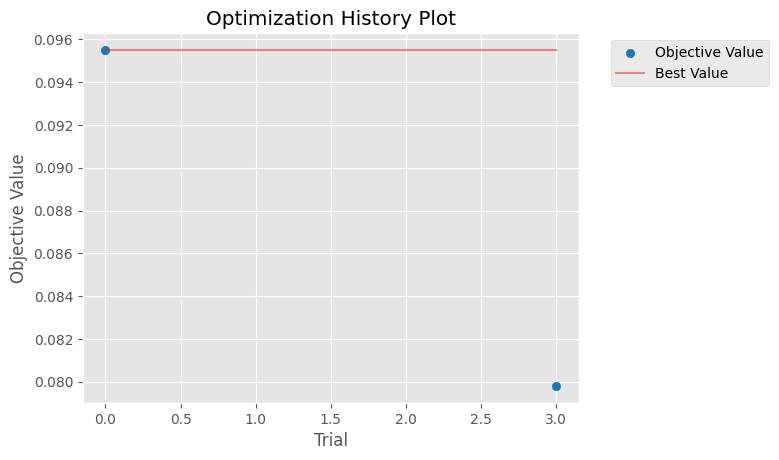

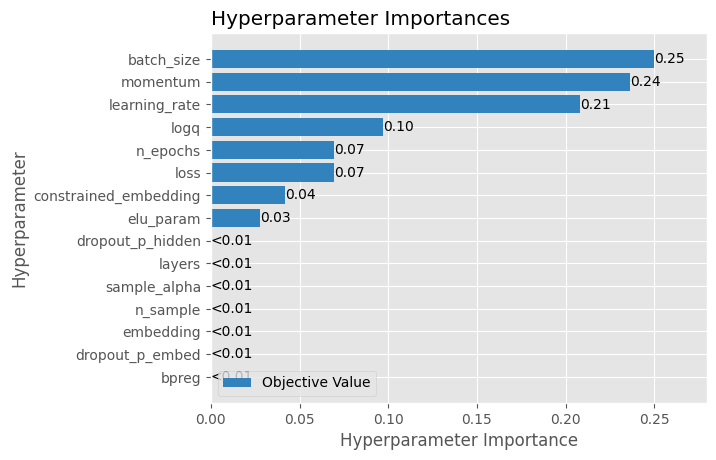

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_bpreg,params_constrained_embedding,params_dropout_p_embed,...,state,Recall@1,Recall@5,Recall@10,Recall@20,MRR@1,MRR@5,MRR@10,MRR@20,search_space_id
0,0,0,0.095504,2024-09-15 09:20:52.281369,2024-09-15 14:11:37.780515,0 days 04:50:45.499146,144.0,1.10,False,0.4,...,COMPLETE,0.095504,0.304214,0.463630,0.642856,0.095504,0.167578,0.188569,0.201018,1.0
1,1,1,NaN,2024-09-15 14:42:08.082302,2024-09-15 14:42:08.184307,0 days 00:00:00.102005,NaN,NaN,False,NaN,...,FAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,NaN,2024-09-15 14:42:51.138798,2024-09-15 14:42:51.257014,0 days 00:00:00.118216,NaN,NaN,True,NaN,...,FAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,0.079806,2024-09-15 14:53:59.292061,2024-09-15 18:08:46.453914,0 days 03:14:47.161853,224.0,0.55,True,0.3,...,COMPLETE,0.079806,0.317993,0.505194,0.696077,0.079806,0.159415,0.184235,0.197555,4.0


In [ ]:
warnings.filterwarnings('ignore')
# visualize optuna results for gru4rec
# Load study from pickle file
with open('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_gru4rec.pkl', 'rb') as f:
    study = pickle.load(f)

# Load trials data from CSV
trials_df = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/results/optuna_vis_gru4rec.csv')

# Optuna visualizations
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

# Display the trials DataFrame
display(trials_df)

#optuna.visualization.matplotlib.plot_parallel_coordinate(study)
#plt.show()
#optuna.visualization.matplotlib.plot_slice(study)
#plt.show()
#optuna.visualization.matplotlib.plot_edf(study)
#plt.show()

# Combiniation Idea 1: Using GRU4Rec's pre-trained item embeddings in Ex2Vec training

We want to extract the pre-trained item embeddings after training the GRU4Rec model and insert them into Ex2Vec instead of its initial ones. This is done with the idea of bringing in dynamic, intra-session item information as part of Ex2Vec training.

In [ ]:
# train Ex2Vec (with GRU embeddings) with best parameters found through hyperparameter optim
ex2vec_gruembds_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec.json') #get parameter string of best ex2vec parameters

command = f'python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -ps {ex2vec_gruembds_best_param_str} -t N -n ex2vec_gruembds_finaltrain_DEL -ep /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams_SM_DEL.pt -ud 1' #re-run training with best parameters
get_ipython().system(command)

The size of the training set is: 2173
The size of the validation set is: 308
The size of the test set is: 626
The size of the combined (train+val) set is: 2481
Ex2Vec model is created with the following parameters for this run:

alias:ex2vec_gruembds_finaltrain_DEL__BS512LR0.0003208416119525183L_DIM64N_EP5
num_epoch:5
batch_size:512
optimizer:adam
lr:0.0003208416119525183
rmsprop_alpha:0.6000000000000001
momentum:0.8
n_users:5
n_items:186
latent_dim:64
num_negative:0
l2_regularization:8.400584873492367e-05
use_cuda:True
device_id:0
pretrain:False
pretrain_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/Ex2Vec_pretrained.pt
model_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/{}_Epoch{}_f1{:.4f}.pt
chckpt_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/chckpts/{}_Epoch{}_f1{:.4f}.pt
Using validation set for evaluation

Started training model:  ex2vec_gruembds_finaltrain_DEL__BS512LR0.0003208416119525183L_DIM64N_EP5
Epoch 0 s

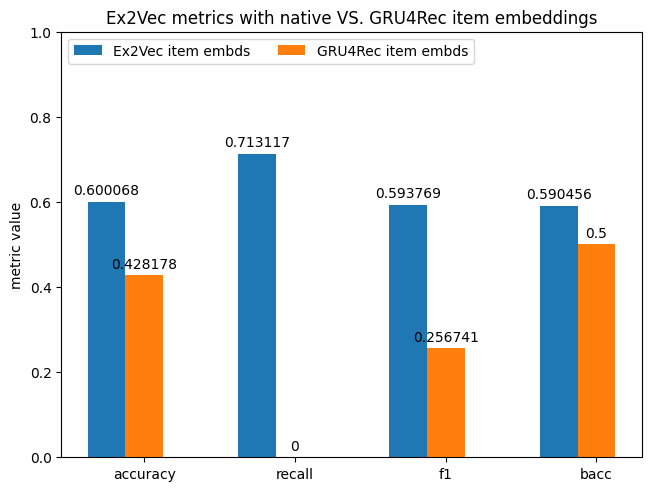

In [ ]:
# load all trained model information
trained_models_df = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/results/best_models.csv')

# extract metrics from ex2vec without VS with gru4rec embds
ex2vec_rows = trained_models_df[trained_models_df['model_name'].str.contains('ex2vec_baseline_finaltrain|ex2vec_gruembds_finaltrain')]

before_after_lists = []
for metric_str in ex2vec_rows['results']: # acc=0.64, recall=0.85, f1=0.62, bacc=0.64
    metrics_list = metric_str.split(', ') # [acc=0.64, recall=0.85, f1=0.62, bacc=0.64]
    metrics_values = [float(metric.split('=')[1]) for metric in metrics_list] # [0.64, 0.85, 0.62, 0.64]
    before_after_lists.append(metrics_values)

metrics = ('accuracy', 'recall', 'f1', 'bacc')
metric_dict = {
    'Ex2Vec item embds': tuple(before_after_lists[0]),
    'GRU4Rec item embds': tuple(before_after_lists[1]),
}

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for k,v in metric_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, v, width, label=k)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric value')
ax.set_title('Ex2Vec metrics with native VS. GRU4Rec item embeddings')
ax.set_xticks(x + width, metrics)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 1)

plt.show()

In [ ]:
# visualize optuna results for ex2vec
# Load study from pickle file
with open('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec_gruembds.pkl', 'rb') as f:
    study = pickle.load(f)

# Load trials data from CSV
trials_df = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/results/optuna_vis_ex2vec_gruembds.csv')

# Optuna visualizations
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

optuna.visualization.matplotlib.plot_parallel_coordinate(study)
plt.show()

optuna.visualization.matplotlib.plot_slice(study)
plt.show()

optuna.visualization.matplotlib.plot_edf(study)
plt.show()

# Display the trials DataFrame
display(trials_df)

# Combination Idea 2: GRU4Rec next-item re-ranking by combining relevance scores with Ex2Vec interest scores

## Loading Ex2Vec for Inference

In [ ]:
# load ex2vec best parameters and use them as config
ex2vec_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec.json')
ex2vec_config = OrderedDict([x.split('=') for x in ex2vec_best_param_str.split(',') if "=" in x])

config = config = {
    "alias": 'ex2vec_baseline_finaltrain_DEL',
    "num_epoch": int(ex2vec_config['num_epoch']),
    "batch_size": int(ex2vec_config['batch_size']),
    "optimizer": 'adam',
    "lr": float(ex2vec_config['learning_rate']),
    "rmsprop_alpha": float(ex2vec_config['rmsprop_alpha']),
    "momentum": float(ex2vec_config['momentum']),
    "n_users": 5, # change to 463 - check github
    "n_items": 186, # change to 879
    "latent_dim": 64,
    "num_negative": 0,
    "l2_regularization": float(ex2vec_config['l2_regularization']),
    "use_cuda": True,
    "device_id": 0,
    "pretrain": True,
    "pretrain_dir": "/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/ex2vec_baseline_finaltrain_DEL__BS512LR0.0003208416119525183L_DIM64N_EP30_Epoch29_f10.4760.pt",
    "model_dir": "/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/{}_Epoch{}_f1{:.4f}.pt",
    "chckpt_dir":"/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/chckpts/{}_Epoch{}_f1{:.4f}.pt",
}

In [ ]:
# instantiate ex2vec model and set to eval mode for inference
ex2vec_pre = Ex2VecEngine(config)
ex2vec_pre.model.eval()

/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/ex2vec.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ex2vec_pre.load_state_dict(torch.load(config['pretra

Ex2Vec(
  (user_lamb): Embedding(5, 1)
  (user_bias): Embedding(5, 1)
  (item_bias): Embedding(186, 1)
  (embedding_user): Embedding(5, 64)
  (embedding_item): Embedding(186, 64)
  (logistic): Sigmoid()
)

## Loading GRU4Rec for inference

In [ ]:
# load current best GRU4Rec model and put it into eval mode for inference
gru4rec_path = '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams_SM_DEL.pt'
gru = torch.load(gru4rec_path)
gru.model.eval()

<ipython-input-8-9f114351fd71>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gru = torch.load(gru4rec_path)


GRU4RecModel(
  (DE): Dropout(p=0.30000000000000004, inplace=False)
  (G): ModuleList(
    (0): GRUCell(64, 64)
  )
  (D): ModuleList(
    (0): Dropout(p=0.15000000000000002, inplace=False)
  )
  (Wy): Embedding(183, 64, sparse=True)
  (By): Embedding(183, 1, sparse=True)
)

## Choose data for inference

In [ ]:
# prepare test data for inference
test_data_path = '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_test.csv'
test_data = pd.read_csv(test_data_path, sep=',', converters={"relational_interval": literal_eval})
n_unique_users = test_data['userId'].nunique() # count number of unique user histories

In [ ]:
"""

n_random_users = 10 # get histories of 10 unique users
n_seqs_per_user = 10

random_users = np.random.choice(test_data['userId'], size=n_random_users)
test_data_sm = test_data[test_data['userId'].isin(random_users)]
# filter out only users with >= 10 sessions
test_data_sm = test_data_sm.groupby('userId').filter(lambda x: x['SessionId'].nunique() >= n_seqs_per_user)

def split_off_sessions(user_df, n):

  #Helper function for slicing out the first n sessions from a user history.

  unique_sessions = user_df['SessionId'].unique()
  first_n_sessions = unique_sessions[:n]
  return user_df[user_df['SessionId'].isin(first_n_sessions)]

n = 10
test_data_sm = test_data_sm.groupby('userId').apply(lambda x: split_off_sessions(x,n)).reset_index(drop=True)
test_data_sm
test_data = test_data_sm
"""

## Performance comparison

In [ ]:
# prepare variables for results tables and experiments
ex2vec_model_name = os.path.basename(config['pretrain_dir']).split('.pt')[0]
gru4rec_model_name = os.path.basename(gru4rec_path).split('.pt')[0]
BATCH_SIZE = 50

# inference run without combination
cutoff = [5, 10, 20]
eval_res = batch_eval(gru=gru, test_data=test_data, cutoff=cutoff, batch_size=BATCH_SIZE, ex2vec=ex2vec_pre.model)

baseline_recalls = ''
baseline_mrrs = ''
for i, c in enumerate(cutoff):
  print('\nRecall@{}: {:.6f} MRR@{}: {:.6f}'.format(c, eval_res[0][c], c, eval_res[1][c]))
  baseline_recalls += 'Recall@{}={:.6f}'.format(c, eval_res[0][c])
  baseline_mrrs += 'MRR@{}={:.6f}'.format(c, eval_res[1][c])

  if i != (len(cutoff) -1):
    baseline_recalls += ','
    baseline_mrrs += ','

Using existing item ID map
The dataframe is not sorted by SessionId, sorting now
Data sorting took 0.02s

Recall@5: 0.383291 MRR@5: 0.244414

Recall@10: 0.506573 MRR@10: 0.260902

Recall@20: 0.672550 MRR@20: 0.272343


In [ ]:
#import evaluation
combination_path = '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/results/score_combination_DEL.csv'
combination_modes = ['direct', 'weighted', 'boosted', 'mult']
topk_list = [20, 50, 100] # set different k for top-k experiments
alpha_list = [0.1, 0.3, 0.9] # set different alpha's for experiment (alpha = tradeoff between the models)

for topk in topk_list:
    for combination_mode in combination_modes:
        eval_res = evaluation.batch_eval(gru=gru, test_data=test_data, cutoff=cutoff, batch_size=BATCH_SIZE, ex2vec=ex2vec_pre.model, combination=combination_mode, k=topk, alpha_list=alpha_list)

        for i, alpha in enumerate(alpha_list):
            recalls = ''
            mrrs = ''
            print(['Recall@{} for alpha={}, combination_mode={}, k={}: {:.6f} MRR@{}: {:.6f}'.format(c, alpha, combination_mode, topk, eval_res[0][c][i], c, eval_res[1][c][i]) for c in cutoff])

            recalls += ','.join(['Recall@{}={:.6f}'.format(c, eval_res[0][c][i]) for c in cutoff])
            mrrs += ','.join(['MRR@{}={:.6f}'.format(c, eval_res[1][c][i]) for c in cutoff])

            # log current run of combination idea 2
            combination_row = {
                'gru4rec_model': gru4rec_model_name,
                'ex2vec_model': ex2vec_model_name,
                'seq_len': 50,
                'batch_size': BATCH_SIZE,
                'combination_mode':combination_mode,
                'alpha': alpha,
                'k':topk,
                'n_user_histories': str(n_unique_users),
                'recalls': recalls,
                'mrrs': mrrs,
                'baseline_recalls': baseline_recalls,
                'baseline_mrrs': baseline_mrrs
            }

            combination_df = pd.DataFrame([combination_row])

            if not os.path.isfile(combination_path):
                combination_df.to_csv(combination_path, mode='w', index=False, header=True)
            else:
                combination_df.to_csv(combination_path, mode='a', index=False, header=False)

Using existing item ID map
The dataframe is not sorted by SessionId, sorting now
Data sorting took 0.01s
['Recall@5 for alpha=0.1, combination_mode=direct, k=20: 0.000034 MRR@5: 0.000017', 'Recall@10 for alpha=0.1, combination_mode=direct, k=20: 0.000034 MRR@10: 0.000017', 'Recall@20 for alpha=0.1, combination_mode=direct, k=20: 0.000134 MRR@20: 0.000023']
['Recall@5 for alpha=0.3, combination_mode=direct, k=20: 0.000034 MRR@5: 0.000017', 'Recall@10 for alpha=0.3, combination_mode=direct, k=20: 0.000034 MRR@10: 0.000017', 'Recall@20 for alpha=0.3, combination_mode=direct, k=20: 0.000134 MRR@20: 0.000023']
['Recall@5 for alpha=0.9, combination_mode=direct, k=20: 0.000034 MRR@5: 0.000017', 'Recall@10 for alpha=0.9, combination_mode=direct, k=20: 0.000034 MRR@10: 0.000017', 'Recall@20 for alpha=0.9, combination_mode=direct, k=20: 0.000134 MRR@20: 0.000023']
Using existing item ID map
The dataframe is not sorted by SessionId, sorting now
Data sorting took 0.03s
['Recall@5 for alpha=0.1, co

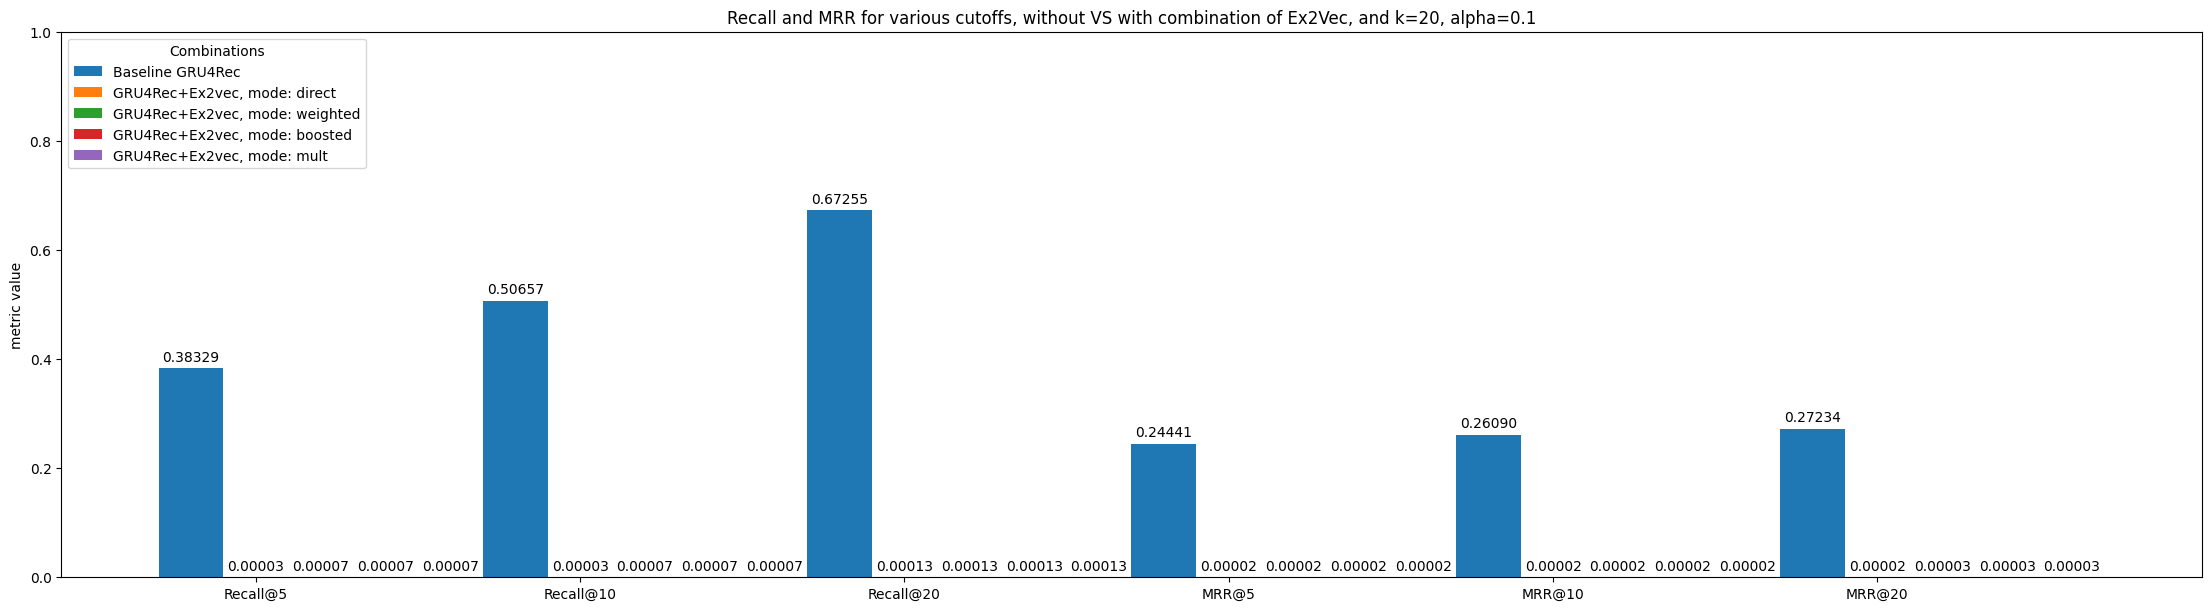

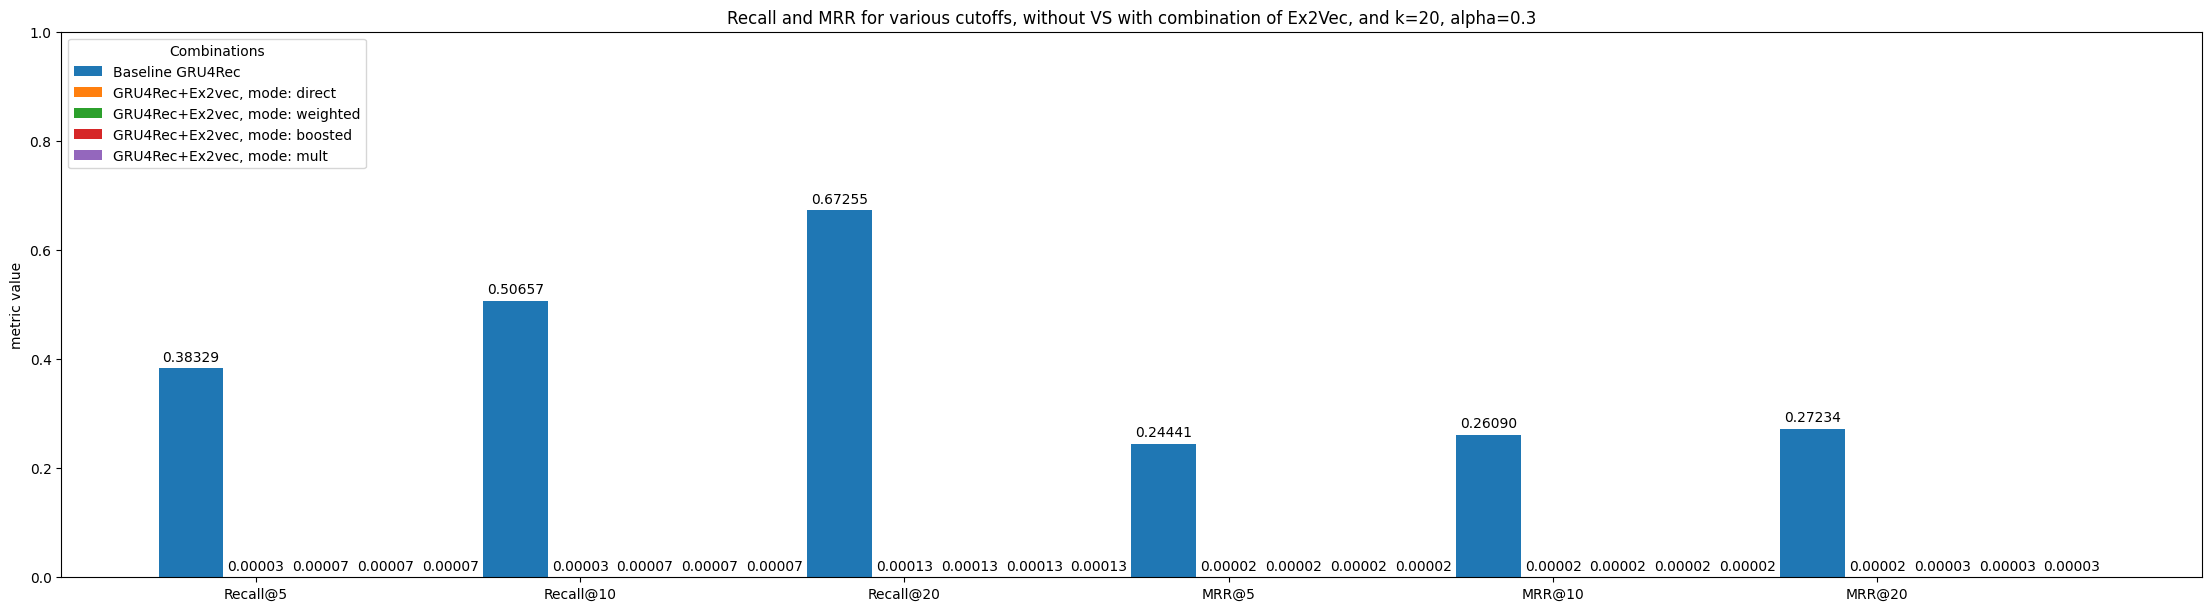

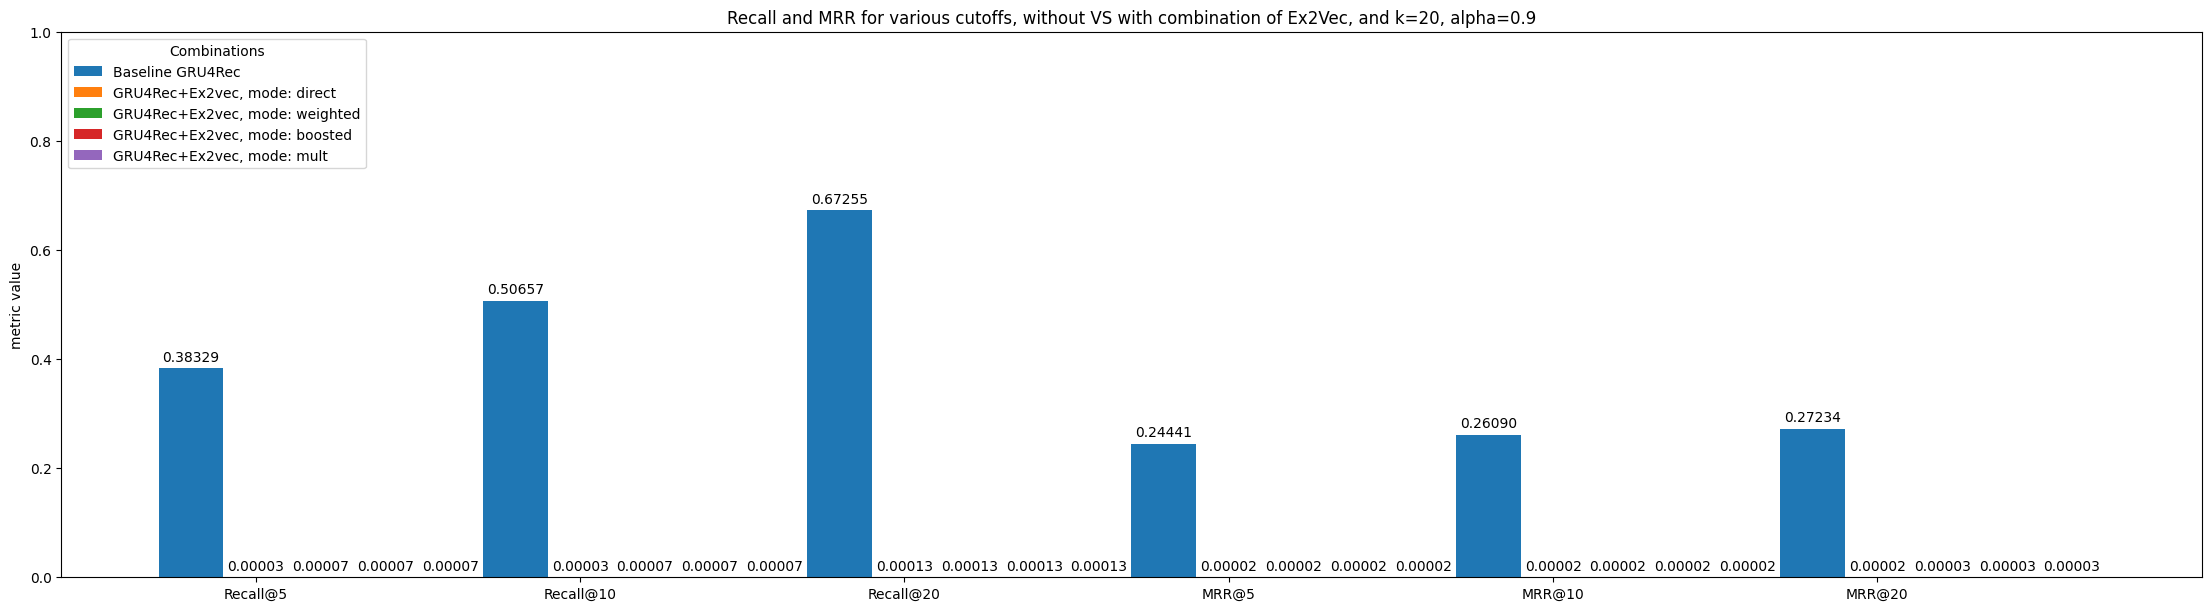

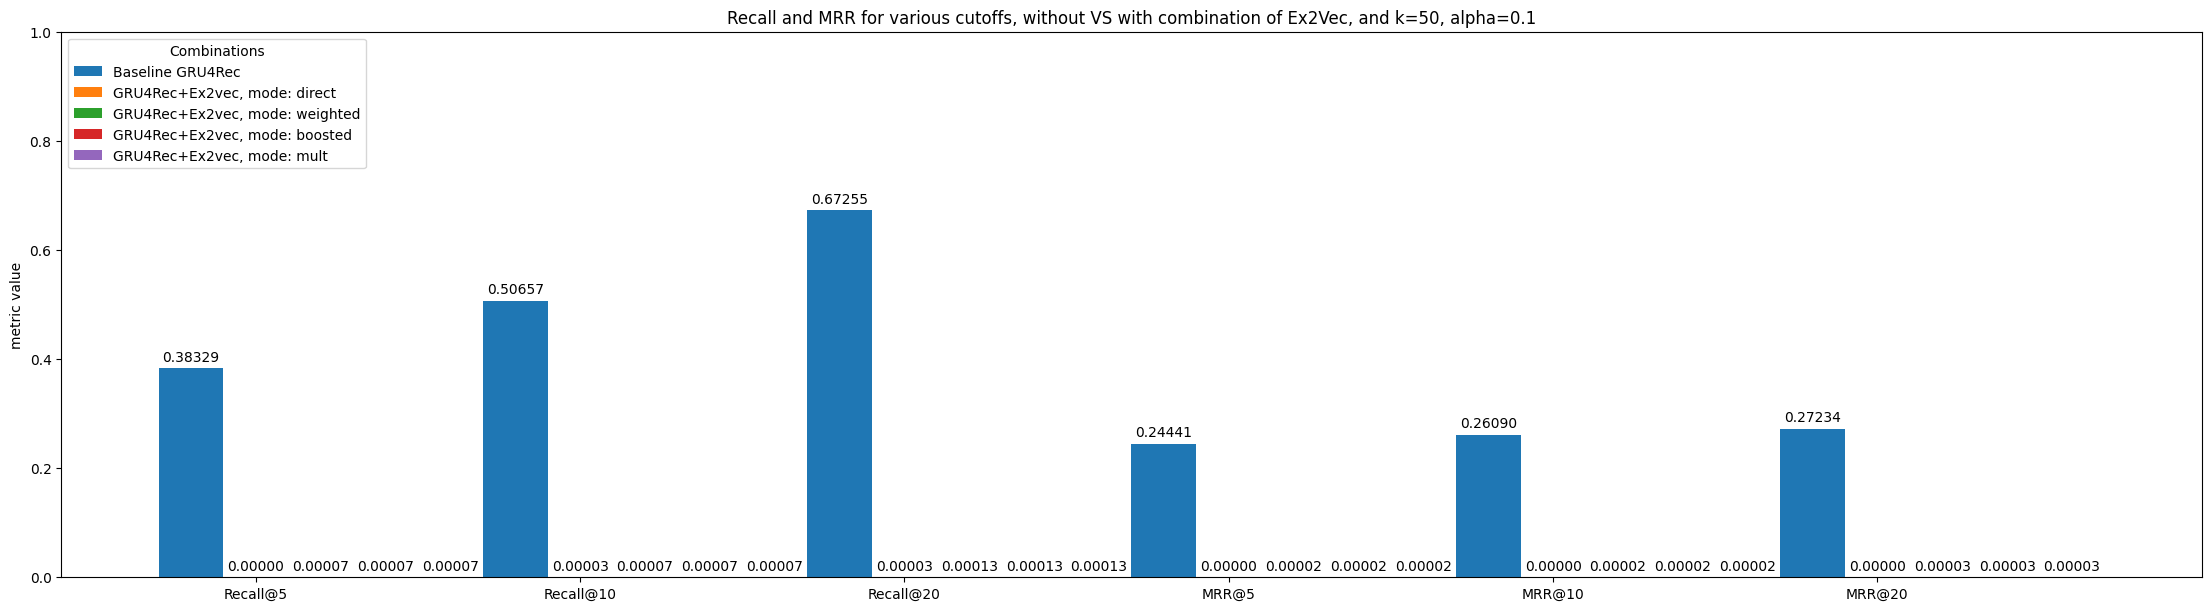

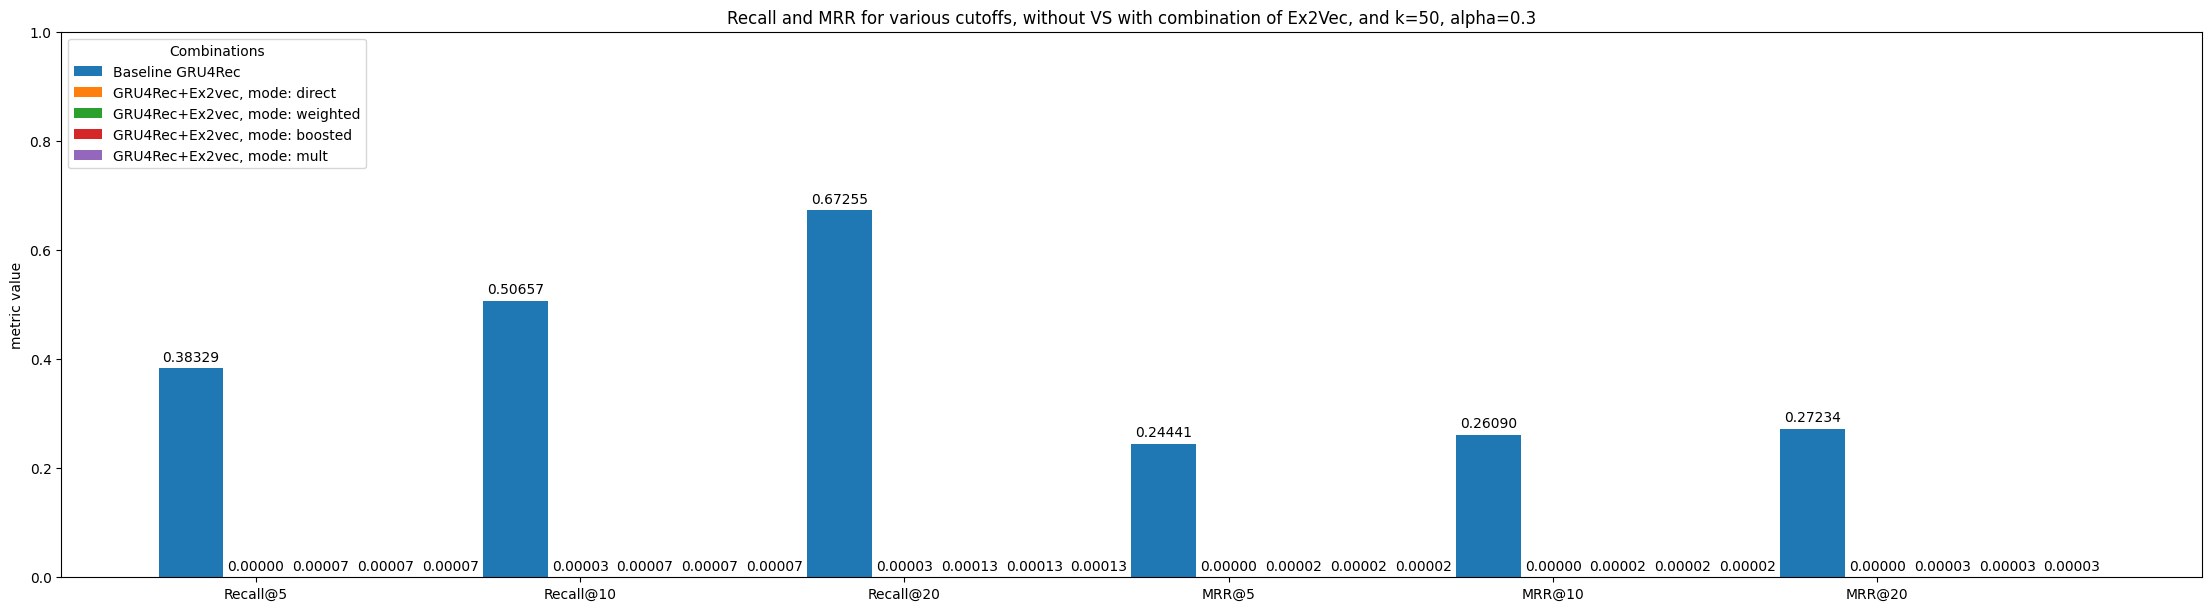

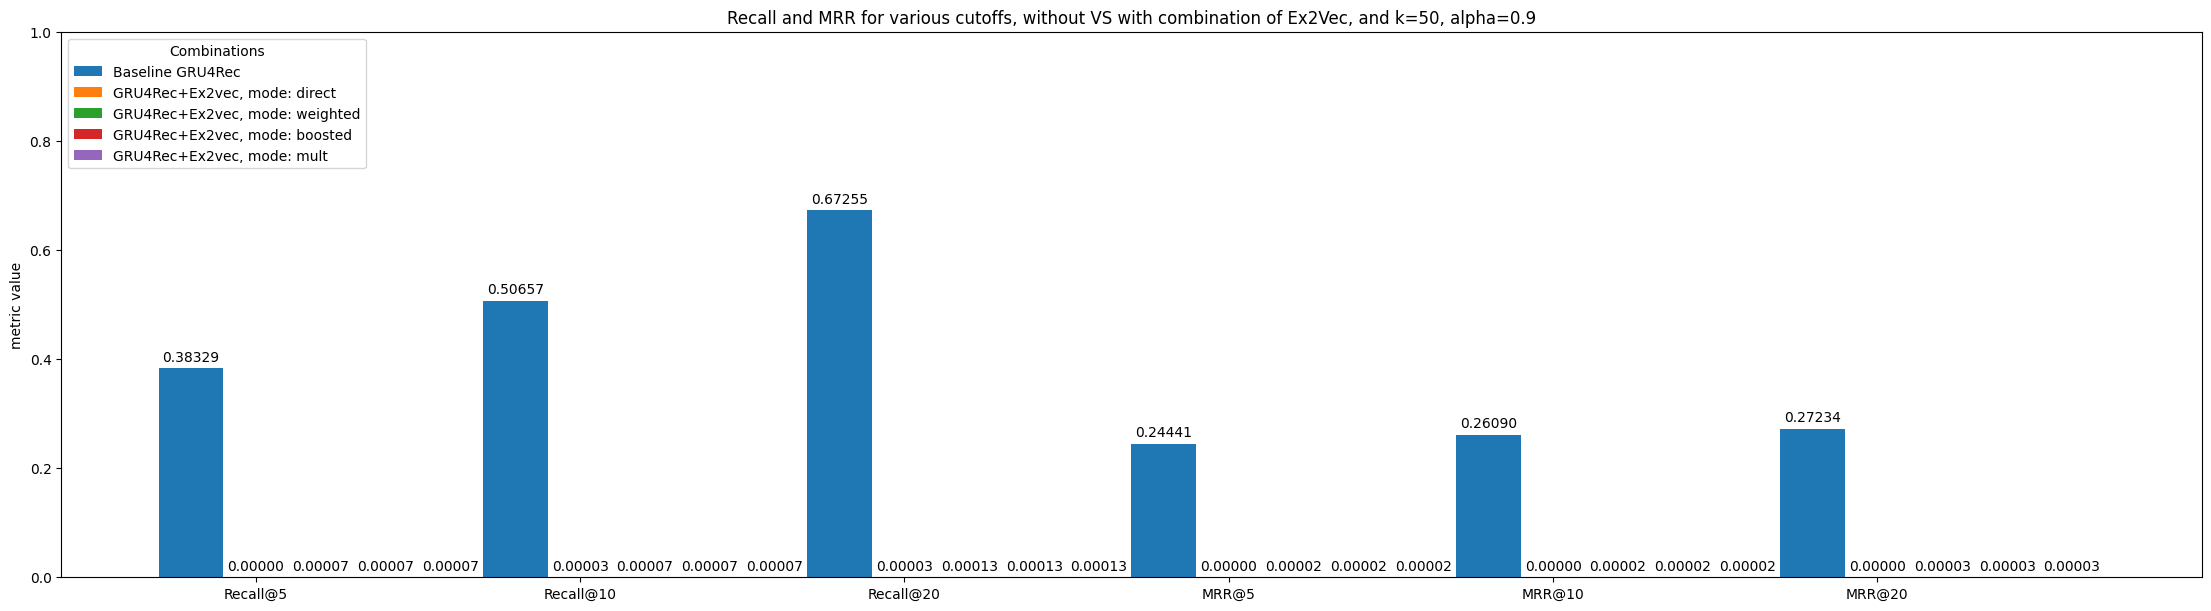

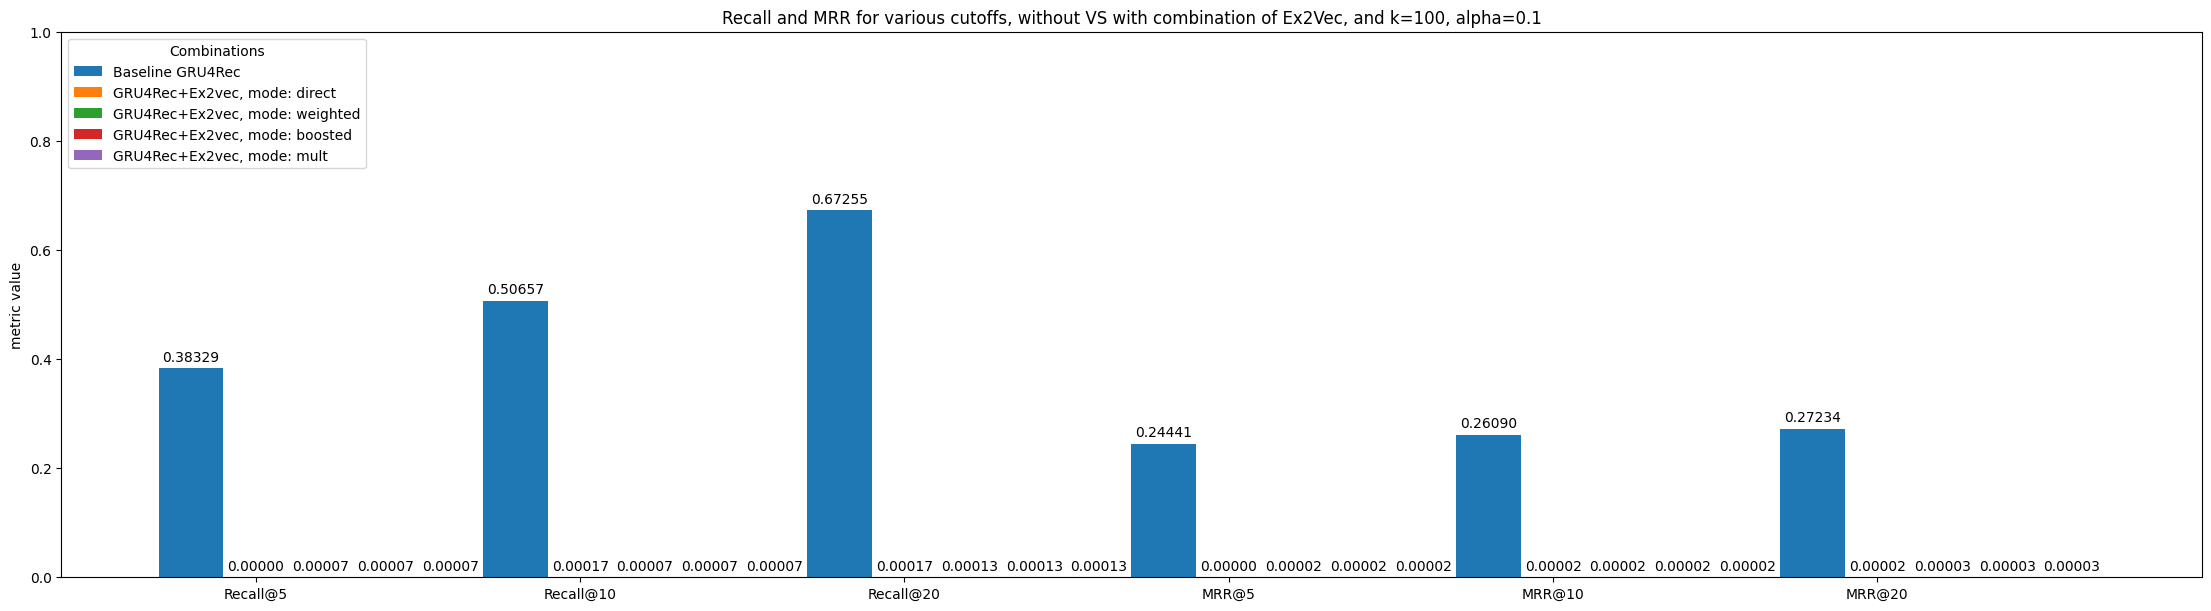

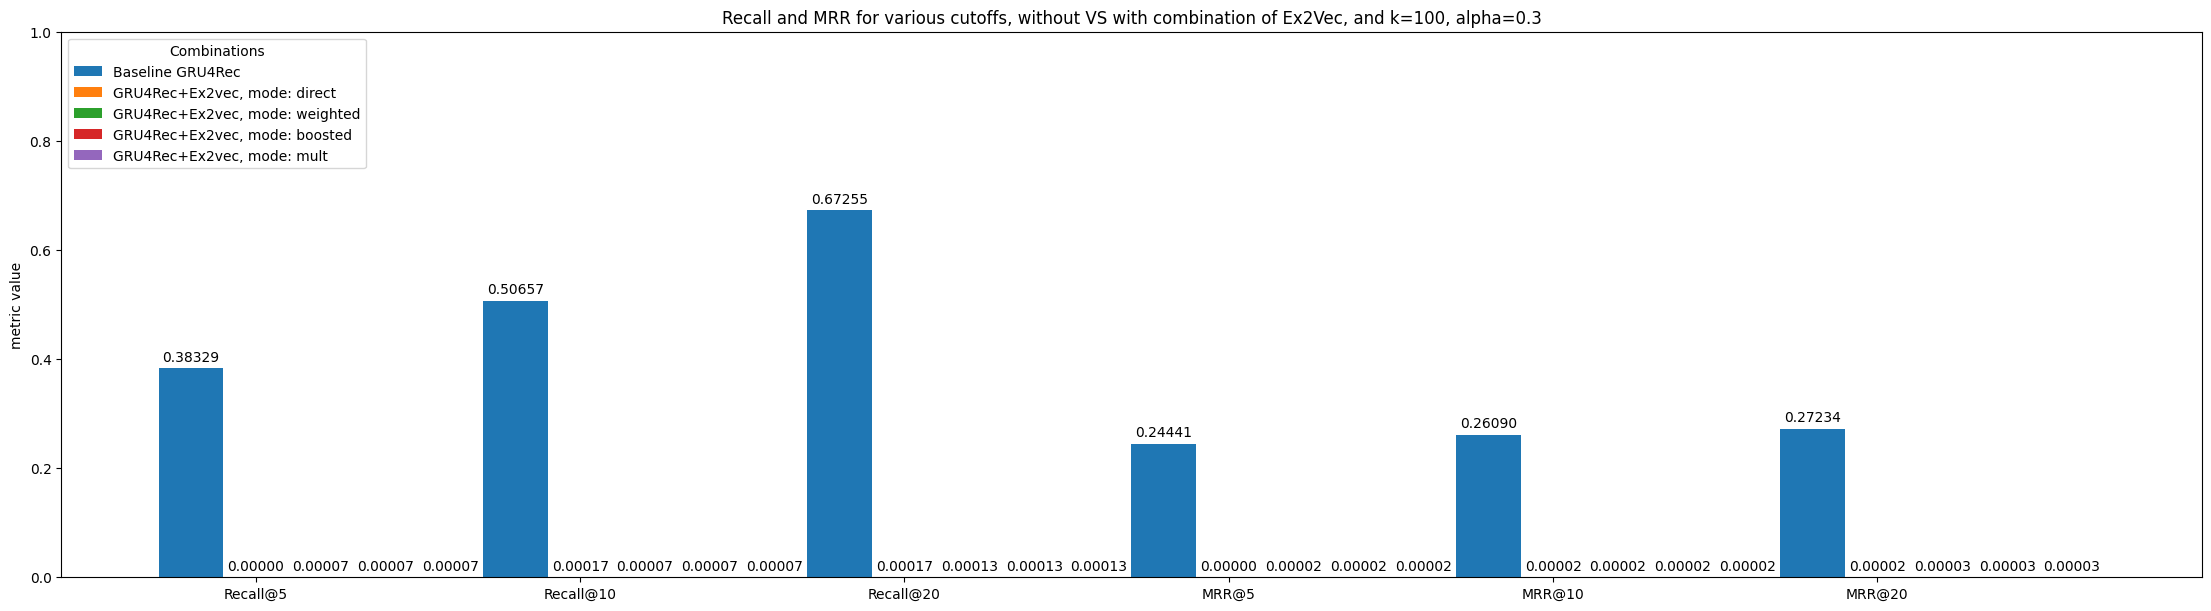

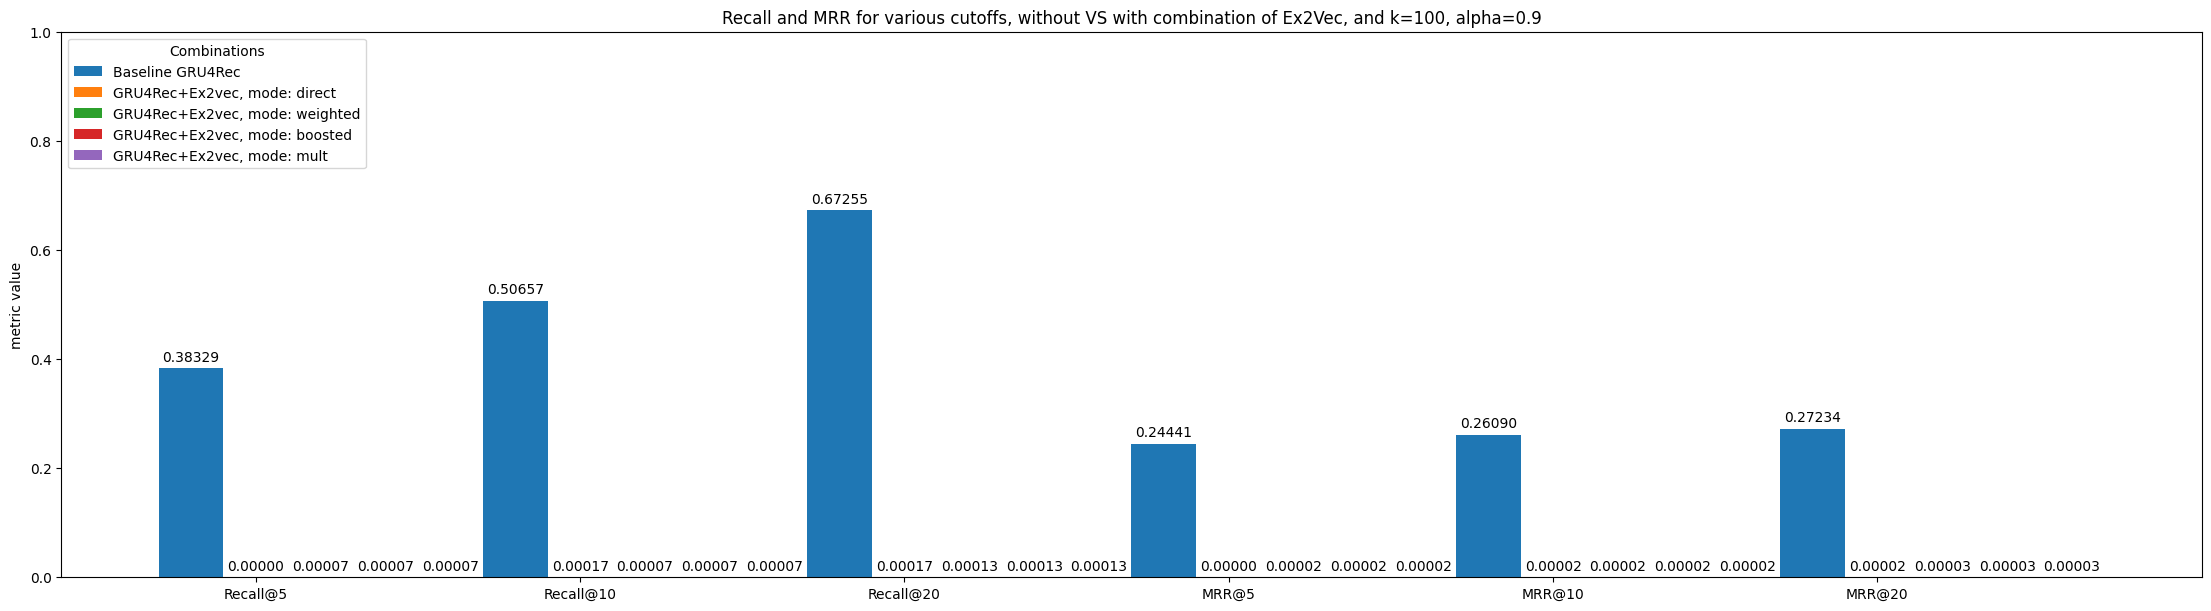

In [ ]:
# for each k and alpha, print the performance bar plots
for topk in topk_list:
    for alpha in alpha_list:
        score_comb_df = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/results/score_combination_DEL.csv')
        gru4rec_rows = score_comb_df[score_comb_df['k'] == topk] # filter out rows for a certain k

        # x axis values
        gru4rec_combi_metrics = tuple([f"Recall@{c}" for c in cutoff] + [f"MRR@{c}" for c in cutoff])
        x = np.arange(len(gru4rec_combi_metrics))

        metrics_dict = {}
        for recalls, mrrs, baseline_recalls, baseline_mrrs, combination_mode in zip(gru4rec_rows['recalls'], gru4rec_rows['mrrs'], gru4rec_rows['baseline_recalls'], gru4rec_rows['baseline_mrrs'], gru4rec_rows['combination_mode']):
            # split out values, e.g. Recall@1=0.2433,Recall@5=0.453,MRR@1=0.123,MRR@5=0.431
            baseline_recall_vals = [float(recall.split('=')[1]) for recall in baseline_recalls.split(',')]
            baseline_mrr_vals = [float(mrr.split('=')[1]) for mrr in baseline_mrrs.split(',')]
            metrics_before = baseline_recall_vals + baseline_mrr_vals

            recall_vals = [float(recall.split('=')[1]) for recall in recalls.split(',')]
            mrr_vals = [float(mrr.split('=')[1]) for mrr in mrrs.split(',')]
            metrics_after = recall_vals + mrr_vals

            # add all before and after metrics to dict as tuples
            metrics_dict["Baseline GRU4Rec"] = tuple(metrics_before)
            metrics_dict[f"GRU4Rec+Ex2vec, mode: {combination_mode}"] = tuple(metrics_after)

        width = 0.2
        multiplier = 0
        fig, ax = plt.subplots(figsize=(22,6), layout='constrained')

        for k,v in metrics_dict.items():
            offset = width * multiplier
            rects = ax.bar(x + offset, v, width, label=k)
            ax.bar_label(rects, labels=[f"{va:.5f}" for va in v], padding=3)
            multiplier += 1

        ax.set_ylabel('metric value')
        ax.set_title(f'Recall and MRR for various cutoffs, without VS with combination of Ex2Vec, and k={topk}, alpha={alpha}')
        ax.set_xticks(x + width, gru4rec_combi_metrics)
        ax.legend(title='Combinations', loc='upper left', ncols=1)
        ax.set_ylim(0, 1)

        plt.show()

<ipython-input-47-5eafef5c227e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=df_combination, palette='Set2')


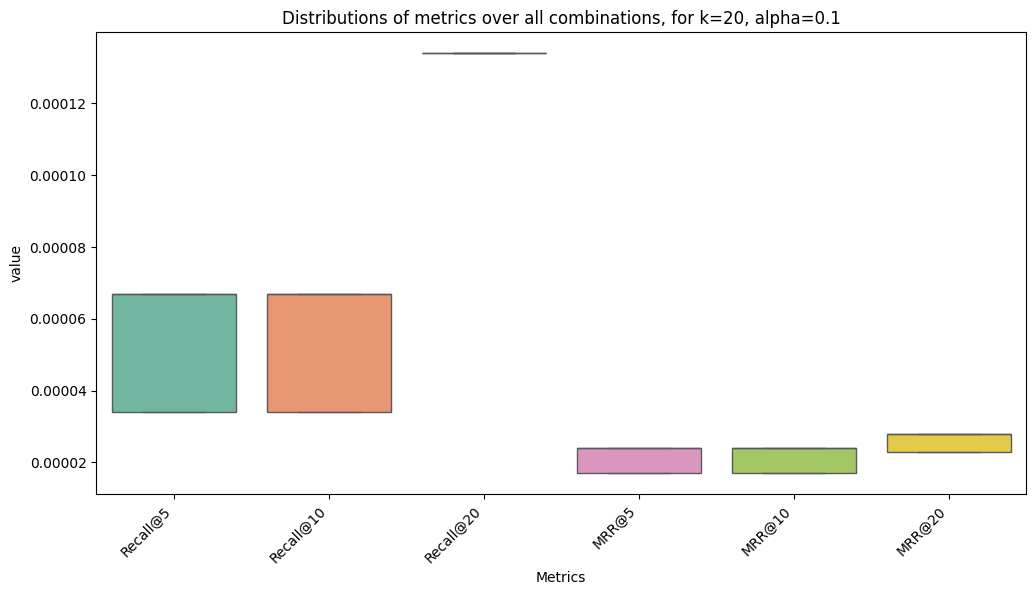

<ipython-input-47-5eafef5c227e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=df_combination, palette='Set2')


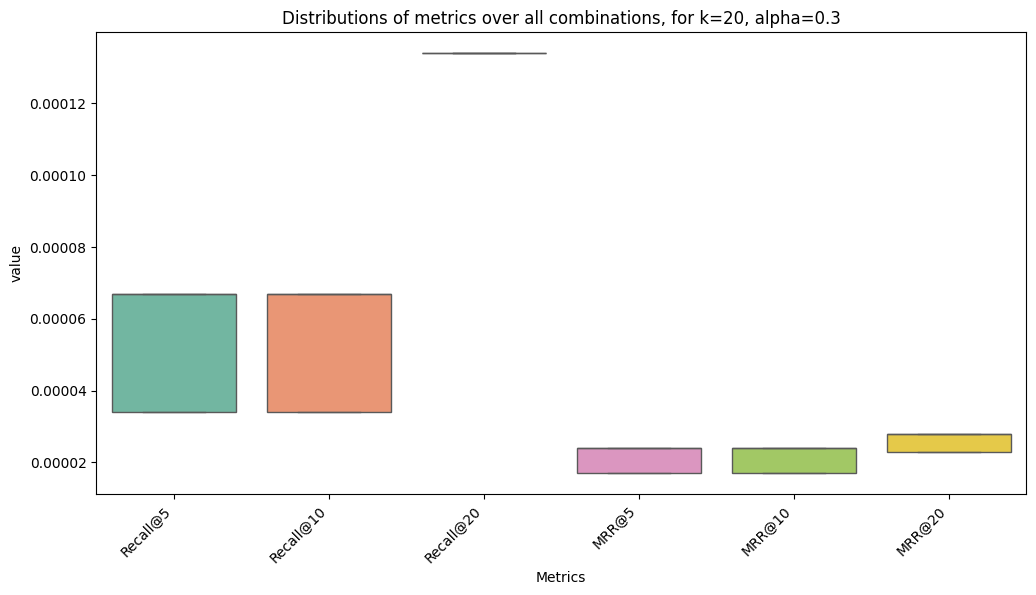

<ipython-input-47-5eafef5c227e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=df_combination, palette='Set2')


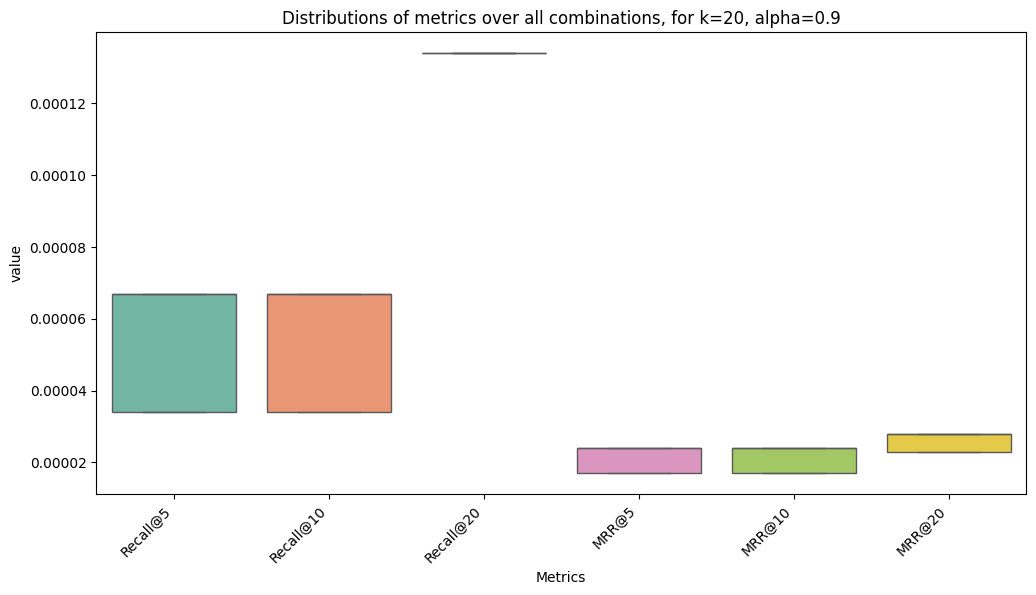

<ipython-input-47-5eafef5c227e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=df_combination, palette='Set2')


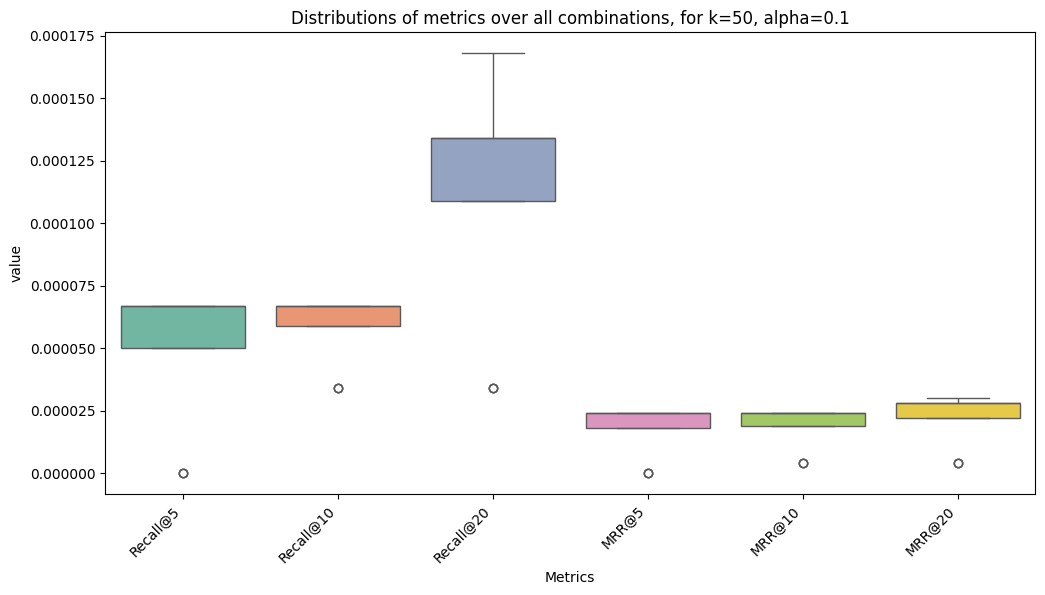

<ipython-input-47-5eafef5c227e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=df_combination, palette='Set2')


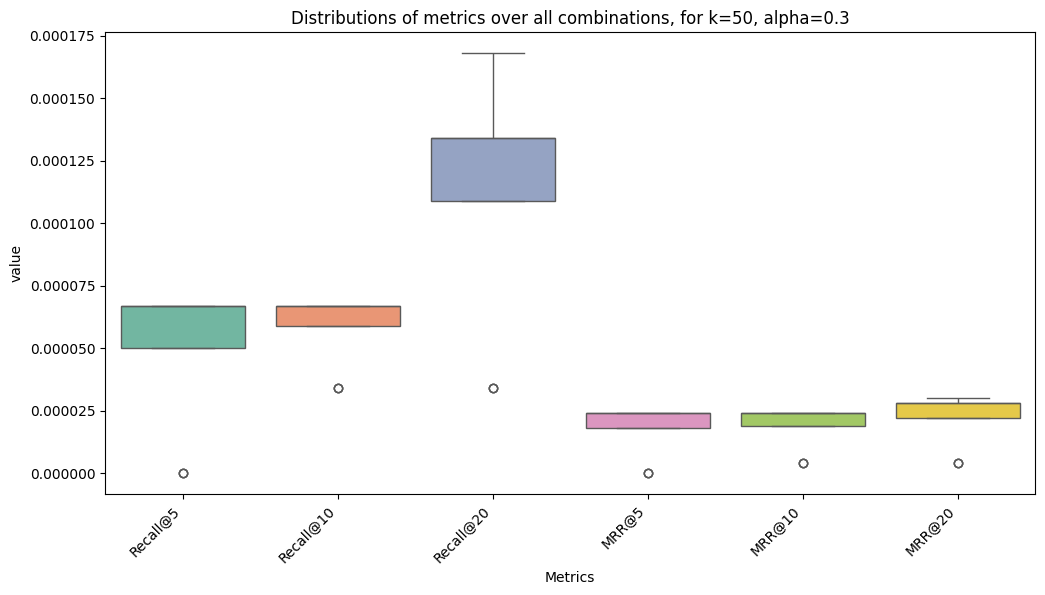

<ipython-input-47-5eafef5c227e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=df_combination, palette='Set2')


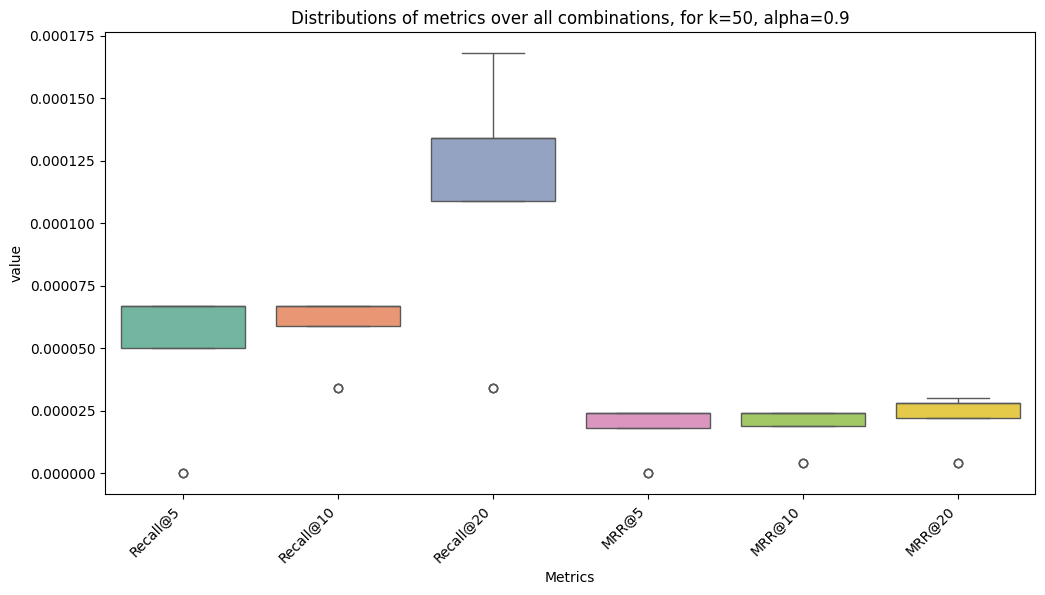

<ipython-input-47-5eafef5c227e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=df_combination, palette='Set2')


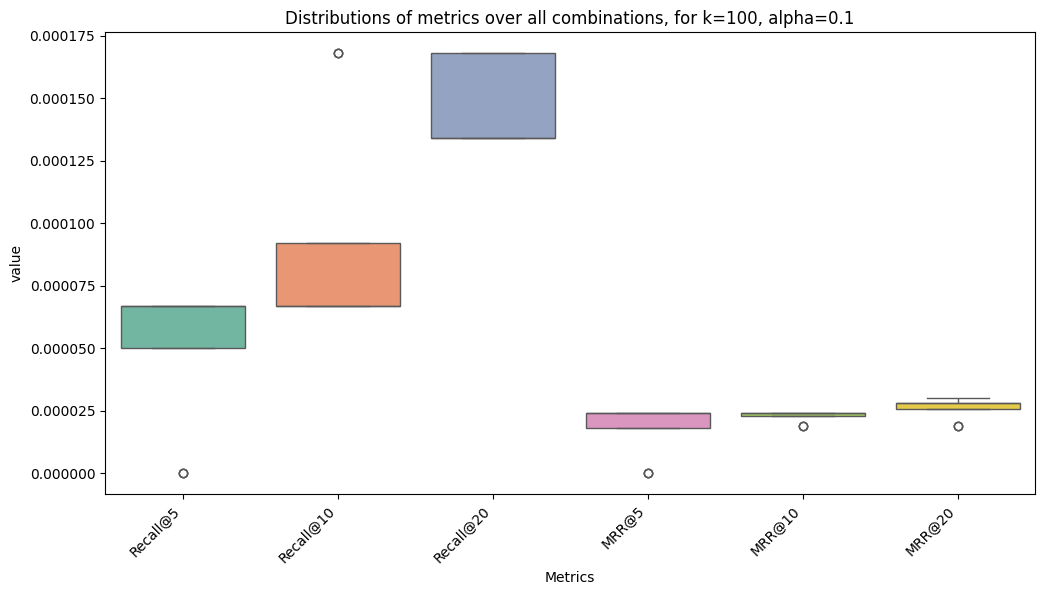

<ipython-input-47-5eafef5c227e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=df_combination, palette='Set2')


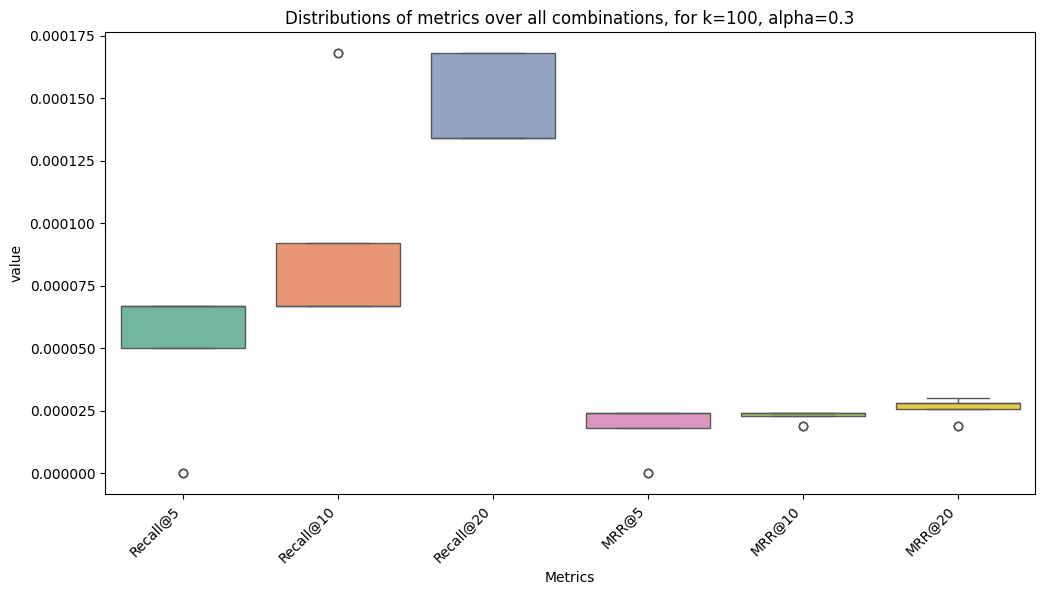

<ipython-input-47-5eafef5c227e>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=df_combination, palette='Set2')


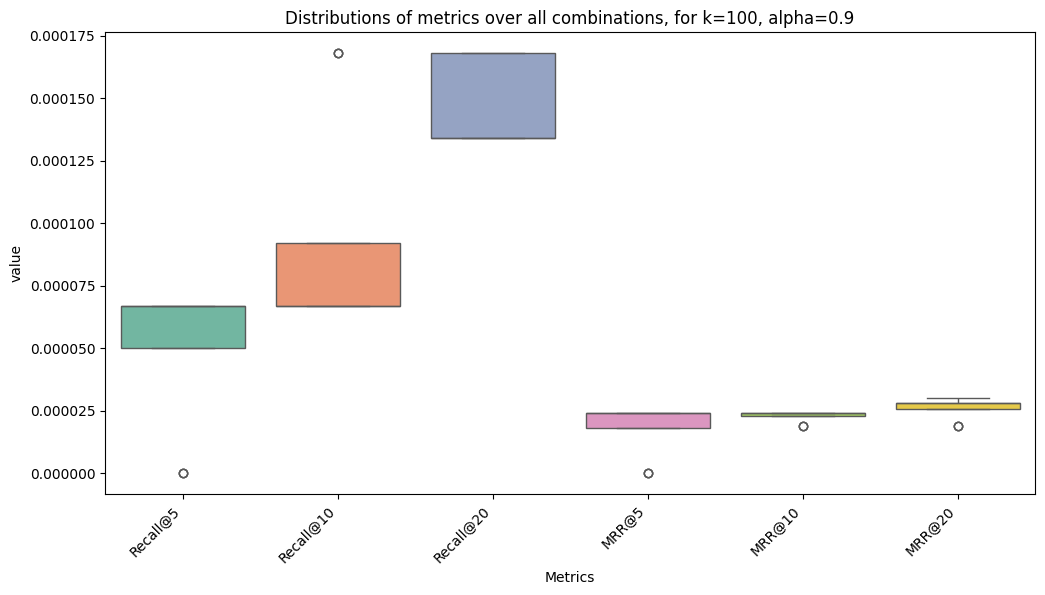

In [ ]:
for topk in topk_list:
    for alpha in alpha_list:
        score_comb_df = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/results/score_combination_DEL.csv')
        gru4rec_rows = score_comb_df[score_comb_df['k'] == topk]  # Filter rows for a certain k

        # Prepare data for plotting
        combination_data = []
        metrics_names = []

        for recalls, mrrs, baseline_recalls, baseline_mrrs, combination_mode in zip(
                gru4rec_rows['recalls'], gru4rec_rows['mrrs'],
                gru4rec_rows['baseline_recalls'], gru4rec_rows['baseline_mrrs'],
                gru4rec_rows['combination_mode']):

            # Split and convert values
            combination_recall_vals = [float(recall.split('=')[1]) for recall in recalls.split(',')]
            combination_mrr_vals = [float(mrr.split('=')[1]) for mrr in mrrs.split(',')]

            # Add to lists for plotting
            combination_data.extend(combination_recall_vals + combination_mrr_vals)
            metrics_names.extend([f"Recall@{c}" for c in cutoff] + [f"MRR@{c}" for c in cutoff])

        df_combination = pd.DataFrame({'Metric': metrics_names, 'Value': combination_data, 'Type': 'Combination'})


        # Plot Boxplots for All Combination Metrics
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Metric', y='Value', data=df_combination, palette='Set2')
        plt.title(f'Distributions of metrics over all combinations, for k={topk}, alpha={alpha}')
        plt.xlabel('Metrics')
        plt.ylabel('value')
        plt.xticks(rotation=45, ha='right')
        plt.show()

## Combination Idea 3: Training GRU4Rec with Ex2Vec as regularization

With GPU times:

-T4: 4.5s/batch -> 4.5hr/epoch

-L4: 3.8s/batch -> 3.5hr/epoch

-A100: 3.8s/batch -> 3.5hr/epoch


Without ex2vec scores: 18batches/s -> 3mins/epoch

In [ ]:
# retrain gru4rec with best params
"""
params: (from https://github.com/hidasib/GRU4Rec/blob/master/README.md)
  -t    Testset path
  -pf   Parameter file path
  -s    Path to save the state dict to
  -m    Calculate recall, MRR etc. at the given list length
  -ik   Item key
  -tk   Timestamp key
  -d    Device
"""

gru4rec_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_gru4rec_DEL.json')

command = f'python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/run.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_combined.csv -ps {gru4rec_best_param_str} -t /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_test.csv -s /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams_ex2vecreg_DEL.pt -m 1 5 10 20 -ik "itemId" -tk "timestamp" -pm recall -lpm -c boosted -ex /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/ex2vec_baseline_finaltrain_DEL__BS512LR0.0003208416119525183L_DIM64N_EP30_Epoch29_f10.4760.pt'
get_ipython().system(command)

[1, 5, 10, 20]
The size of the training set is: 2173
The size of the validation set is: 308
The size of the test set is: 626
The size of the combined (train+val) set is: 2481
Creating GRU4Rec model on device "cuda:0"
SET   loss                    TO   bpr-max               (type: <class 'str'>)
SET   constrained_embedding   TO   True                  (type: <class 'bool'>)
SET   embedding               TO   0                     (type: <class 'int'>)
SET   elu_param               TO   0.0                   (type: <class 'float'>)
SET   layers                  TO   [64]                  (type: <class 'list'>)
SET   n_epochs                TO   5                     (type: <class 'int'>)
SET   batch_size              TO   30                    (type: <class 'int'>)
SET   dropout_p_embed         TO   0.30000000000000004   (type: <class 'float'>)
SET   dropout_p_hidden        TO   0.15000000000000002   (type: <class 'float'>)
SET   learning_rate           TO   0.0011                (type: 

In [ ]:
'1.0' > '0.15'

True